# Generate Fasion Images with Conditional GAN

This kernel is PyTorch GAN Tutorial that based on [PyTorch Conditional GAN by Artur Machado Lacerda](https://www.kaggle.com/arturlacerda/pytorch-conditional-gan). 

For Tutorial, Added step-by-step configuration and comments and test code lines to the base code to make learning easier. And Fixed some code according to PyTorch version update.

Thank you for nice reference!

> Index
```
Step 1. Import Libraries and Load Dataset
     1-a. basic way to load dataset
     1-b. more efficient way to load dataset(with transform) + batch
Step 2. Define Discriminator and Generator
     2-a. discriminator
     2-b. generator
Step 3. Define Loss Function and Optimizing Function
     3-a. loss function
     3-b. optimizing function
Step 4. Define Training Functions
     4-a. training gerenator (get 1 loss and 1 gradient descent)
     4-b. training discriminator (get 1 loss and 1 gradient descent)
Step 5. Train Model
Stpe 6. Test Model
```

## Step 1. Import Libraries and Load Dataset

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

> reference :

1. [Data Loading and Processing Tutorial on PyTorch's documentation](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

- `torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset`and override the following methods:
    - `__len__` so that `len(dataset)` returns the size of the dataset.
    - `__getitem__` to support the indexing such that `dataset[i]` can be used to get i-th sample.
    
2. [torchvision](https://github.com/pytorch/vision)

- the `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision.


### 1-a. Basic way to load dataset

In [3]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:,1:].values.astype('uint8').reshape(-1,28,28)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

In [4]:
dataset = FashionMNIST()

In [5]:
# __getitem__(idx:0) -> return (img, label)
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F30025AD950>, 2)

In [6]:
# show img  == Image.fromarray(self.images[idx])
dataset[0][0]


> TEST CODE | LINE BY LINE


In [7]:
!ls ..

input  lib  working


In [8]:
fashion_df = pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')

In [9]:
fashion_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
fashion_df.iloc[:,1:].values.astype('uint8').shape

(60000, 784)

In [11]:
fashion_df.iloc[:,1:].values.astype('uint8').reshape(-1,28,28).shape

(60000, 28, 28)

In [12]:
images = fashion_df.iloc[:,1:].values.astype('uint8').reshape(-1,28,28)

In [13]:
images[1].shape

(28, 28)

In [14]:
Image.fromarray(images[1])

In [15]:
img = Image.fromarray(images[1])

In [16]:
img

### 1-b. More efficient way to Load dataset(with transform) + batch

In [17]:
transform = transforms.Compose([ # torchvision.transforms
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

> TEST CODE | LINE BY LINE

In [18]:
count = 0
for i,j in iter(data_loader):
    print(i.shape, j.shape)
    count += 1
    if count == 5:
        break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])


## Step 2. Define Discriminator and Generator

### 2-a. Discriminator

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10,10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024), # x = torch.cat([x,c], axis=1) ## x.shape == (64,784), c.shape == (64,10), torch.cat([x,c],axis=1).shape == (64,794)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = x.view(x.size(0), 784)
        x = torch.cat([x,c], axis=1)
        output = self.model(x)
        return output.squeeze()

> TEST CODE | LINE BY LINE



In [20]:
count = 0
print(next(iter(data_loader))[0].shape)


torch.Size([64, 1, 28, 28])


In [21]:
sample_imgs = next(iter(data_loader))[0]

In [22]:
# number of images
sample_imgs.size(0)

64

In [23]:
print(next(iter(data_loader))[0].shape) # [n, c, h, w]
print(next(iter(data_loader))[1].shape) # [n]

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [24]:
sample_imgs = next(iter(data_loader))[0]
sample_labels = next(iter(data_loader))[1]

In [25]:
sample_labels

tensor([9, 0, 8, 7, 7, 6, 5, 7, 0, 7, 5, 4, 5, 4, 6, 8, 6, 9, 4, 1, 6, 9, 2, 9,
        8, 2, 6, 7, 1, 9, 3, 3, 4, 6, 2, 4, 1, 3, 6, 9, 0, 9, 0, 7, 8, 5, 8, 9,
        6, 7, 0, 8, 7, 9, 8, 7, 3, 7, 1, 9, 5, 6, 2, 5])

In [26]:
nn.Embedding(10,10)(sample_labels).shape

torch.Size([64, 10])

In [27]:
nn.Embedding(10,10)(sample_labels)[0]

tensor([-7.0411e-04,  1.6537e+00,  1.1206e+00, -6.4892e-01, -1.0148e+00,
         7.2710e-01,  2.2617e-01,  8.7477e-01, -4.8895e-02, -1.7949e+00],
       grad_fn=<SelectBackward>)

In [29]:
sample_imgs.view(64, 784).shape
sample_x = sample_imgs.view(64, 784)
sample_c = nn.Embedding(10,10)(sample_labels)

In [30]:
sample_x.shape

torch.Size([64, 784])

In [31]:
sample_c.shape

torch.Size([64, 10])

In [32]:
sample_output = torch.cat([sample_x,sample_c], axis=1)
sample_output.shape

torch.Size([64, 794])

### 2-b. Generator

In [33]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10,10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256), # x = torch.cat([z,c], axis=1) ## z.shape == (64,100), c.shape == (64,10), torch.cat([z,c], axis=1).shape == (64,110)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z,c], axis=1)
        output = self.model(x)
        return output.view(x.size(0), 28, 28)

In [34]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

## Step 3. Define Loss Function and Optimizing Function

### 3-a. Loss Function

In [35]:
criterion = nn.BCELoss()

### 3-b. Optimizing Function

In [36]:
d_optimizer = torch.optim.Adam(
    discriminator.parameters(),
    lr = 1e-4
)
g_optimizer = torch.optim.Adam(
    generator.parameters(),
    lr = 1e-4
)

> TEST CODE | LINE BY LINE

In [37]:
print('1e-1 == ', 1e-1)
print('1e-2 == ', 1e-2)
print('1e-3 == ', 1e-3)
print('1e-4 == ', 1e-4)

1e-1 ==  0.1
1e-2 ==  0.01
1e-3 ==  0.001
1e-4 ==  0.0001


In [38]:
discriminator

Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [39]:
print(discriminator.parameters())
print(discriminator.parameters)

<generator object Module.parameters at 0x7f2f5357dd50>
<bound method Module.parameters of Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)>


In [40]:
generator

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [41]:
print(generator.parameters())
print(generator.parameters)

<generator object Module.parameters at 0x7f2f52ea0050>
<bound method Module.parameters of Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)>


In [42]:
d_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [43]:
g_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

## Step 4. Define Training Function

### 4-a. training gerenator (get 1 loss and 1 gradient descent)

In [240]:
def train_generator(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size,100)).cuda() # tensor to GPU
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda() # tensor to GPU
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels) # valid that is image(generated image by generator) is real or fake
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda()) # get loss
    g_loss.backward() # backward pass, back-propagation
    g_optimizer.step() # gradient descent, adjust model parameters
    return g_loss.data
    

> TEST CODE | LINE BY LINE

In [45]:
test_batch_size = 32

In [46]:
torch.randn(test_batch_size, 100)

tensor([[ 1.1683e-01,  3.7786e-01, -2.2574e+00,  ..., -7.7128e-01,
          1.1371e+00, -1.8737e-01],
        [-5.0429e-01, -8.8175e-01,  7.6082e-01,  ..., -1.6669e+00,
         -1.0318e-01,  1.5775e+00],
        [-1.2241e+00,  1.1308e+00,  9.3830e-04,  ..., -9.5064e-01,
         -8.0664e-01,  2.2915e+00],
        ...,
        [ 9.8524e-01,  1.8092e-01,  4.7784e-02,  ...,  1.4418e+00,
          1.1630e+00, -6.1751e-01],
        [ 3.0654e-01, -9.0047e-01, -3.6079e-01,  ..., -7.1346e-01,
          3.4764e-01, -4.0141e-01],
        [ 3.0206e-01,  1.7311e+00, -8.5549e-01,  ...,  1.0750e+00,
          5.1978e-01, -7.8788e-01]])

In [47]:
torch.randn(test_batch_size, 100).shape

torch.Size([32, 100])

In [48]:
Variable(torch.randn(test_batch_size,100)) # same result. it is a tensor-wrapper for calculating gradient.

tensor([[-0.9478,  0.1127, -1.3918,  ..., -0.8587, -1.3781, -0.2971],
        [ 1.6418, -0.5316,  0.1376,  ...,  1.0230, -1.0448, -0.1119],
        [ 1.9113,  1.4307,  1.0834,  ...,  0.0544,  0.4535, -1.9893],
        ...,
        [ 0.0909,  0.0580, -0.0735,  ...,  0.1467,  1.2773,  0.4067],
        [ 1.7708, -0.6505, -0.0892,  ...,  0.0498, -0.2958, -1.2816],
        [ 0.9508,  1.3777,  1.9263,  ...,  0.6973, -0.8065,  0.9849]])

reference :
[PyTorch: Variables and autograd](http://seba1511.net/tutorials/beginner/examples_autograd/two_layer_net_autograd.html)
- A PyTorch Variable is a wrapper around a PyTorch Tensor, and represents a node in a computational graph. 
- If x is a Variable then x.data is a Tensor giving its value, and x.grad is another Variable holding the gradients of x with respect to some scalar value.

[PyTorch 0.4.0 Migration Guide](https://pytorch.org/blog/pytorch-0_4_0-migration-guide/)
- `torch.Tensor` and `torch.autograd.Variable` are now the same class. 
- More precisely, `torch.Tensor` is capable of tracking history and behaves like the old `Variable`; `Variable` wrapping continues to work as before but returns an object of type `torch.Tensor`. This means that you don't need the `Variable` wrapper everywhere in your code anymore


In [49]:
Variable(torch.randn(test_batch_size,100)).shape

torch.Size([32, 100])

In [50]:
np.random.randint(0, 10, test_batch_size)

array([0, 1, 2, 6, 2, 2, 8, 5, 7, 9, 1, 1, 8, 8, 2, 8, 0, 7, 2, 7, 0, 4,
       8, 7, 1, 1, 0, 5, 4, 7, 7, 7])

In [51]:
np.random.randint(0, 10, test_batch_size).shape

(32,)

In [52]:
torch.LongTensor(np.random.randint(0,10,test_batch_size))

tensor([5, 2, 5, 0, 2, 1, 0, 5, 6, 0, 5, 9, 2, 7, 3, 2, 0, 2, 8, 6, 5, 9, 7, 6,
        9, 3, 1, 0, 2, 6, 2, 9])

In [53]:
torch.LongTensor(np.random.randint(0,10,test_batch_size)).shape

torch.Size([32])

In [54]:
z = Variable(torch.randn(test_batch_size,100)).cuda()
fake_labels = Variable(torch.LongTensor(np.random.randint(0,10,test_batch_size))).cuda()
generator(z, fake_labels).shape # [N, H, W]

torch.Size([32, 28, 28])

In [55]:
generator(z, fake_labels).unsqueeze(1).shape # [N, C, H, W]

torch.Size([32, 1, 28, 28])

In [56]:
generator(z, fake_labels).unsqueeze(1).permute(0,2,3,1).shape # [N, H, W, C]

torch.Size([32, 28, 28, 1])

In [57]:
generator(z, fake_labels).unsqueeze(1).permute(0,2,3,1)[0].shape

torch.Size([28, 28, 1])

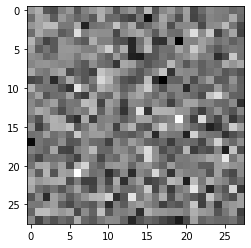

In [58]:
plt.imshow(generator(z, fake_labels).unsqueeze(1).permute(0,2,3,1)[0].cpu().detach().numpy(), cmap='gray');

Since the first differentiation has not yet been performed(before training), the generated fake image is poor enough to be 100% distingushable from the real image(fashion mnist).

In [223]:
z = Variable(torch.randn(test_batch_size, 100), requires_grad=True).cuda()
fake_labels = Variable(torch.LongTensor(np.random.randint(0,10,test_batch_size))).cuda()
fake_images = generator(z, fake_labels)
test_validity = discriminator(fake_images, fake_labels)

In [235]:
z.shape

torch.Size([32, 100])

In [236]:
z

tensor([[-0.4675,  0.2264, -0.8601,  ..., -0.9890,  0.1157, -0.6101],
        [ 0.1600, -1.9441, -0.4669,  ..., -0.3876,  0.5464,  1.2731],
        [-2.4089,  1.5889,  0.7608,  ...,  1.6663, -0.5872, -0.7107],
        ...,
        [ 1.2677, -2.2617,  2.4818,  ...,  1.0016,  1.1522,  0.3218],
        [-0.4643,  0.9287, -0.0273,  ...,  1.3282, -1.7462, -0.0205],
        [ 1.4758,  1.1409,  0.7540,  ..., -0.3996, -0.0862, -0.6769]],
       device='cuda:0', grad_fn=<CopyBackwards>)

In [224]:
z.retain_grad() # there is no grad

In [225]:
test_validity

tensor([0.4974, 0.4991, 0.5045, 0.5017, 0.4988, 0.5026, 0.5022, 0.5034, 0.4990,
        0.5050, 0.5043, 0.5038, 0.4976, 0.4987, 0.4997, 0.5039, 0.4985, 0.4972,
        0.5000, 0.4982, 0.4942, 0.5014, 0.4960, 0.4982, 0.5054, 0.5002, 0.4978,
        0.4933, 0.5051, 0.5047, 0.5071, 0.4998], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [226]:
test_validity.shape

torch.Size([32])

In [227]:
torch.ones(test_batch_size)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [228]:
torch.ones(test_batch_size).shape

torch.Size([32])

In [229]:
test_g_loss = criterion(test_validity, Variable(torch.ones(test_batch_size)).cuda())
test_g_loss

tensor(0.6920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [230]:
test_g_loss.backward()

In [246]:
test_g_loss.data

tensor(0.6920, device='cuda:0')

In [231]:
g_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [232]:
g_optimizer.step()

In [233]:
print(z.grad)

tensor([[-4.1240e-06,  1.8736e-06,  6.2284e-07,  ...,  1.5832e-06,
         -1.6143e-06,  2.8277e-06],
        [-1.9913e-05,  1.8009e-05, -2.3243e-07,  ...,  4.3017e-06,
          4.1391e-06, -1.0925e-05],
        [-1.7492e-06, -4.1320e-06, -9.6672e-06,  ..., -2.3338e-06,
          7.3650e-06, -8.3419e-06],
        ...,
        [-2.8154e-05,  2.6237e-05, -5.3043e-06,  ..., -7.0159e-06,
         -1.5279e-05, -7.3485e-06],
        [-5.1223e-06,  3.9628e-06, -1.0296e-06,  ...,  6.7346e-07,
          5.5685e-06, -9.9309e-06],
        [-1.5715e-05,  6.3579e-07, -6.5957e-06,  ..., -2.7200e-06,
          5.6044e-06, -6.1724e-06]], device='cuda:0')


In [234]:
z.grad.shape

torch.Size([32, 100])

### 4-b. training discriminator (get 1 loss and 1 gradient descent)

In [239]:
def train_discriminator(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    
    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0,10,batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data # get value(scalar)

## Step 5. Train Model

  1%|          | 5/938 [00:00<00:19, 46.66it/s]

epoch : 0


100%|██████████| 938/938 [00:19<00:00, 48.19it/s]


g_loss : 2.044783592224121, d_loss : 0.8055384159088135


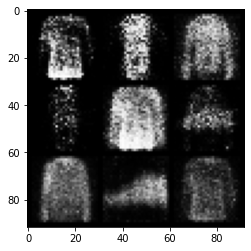

  0%|          | 0/938 [00:00<?, ?it/s]

epoch : 1


100%|██████████| 938/938 [00:19<00:00, 49.16it/s]


g_loss : 2.1420156955718994, d_loss : 0.5989919900894165


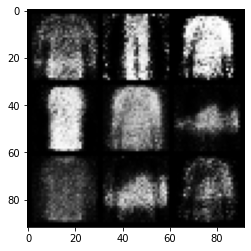

  0%|          | 0/938 [00:00<?, ?it/s]

epoch : 2


100%|██████████| 938/938 [00:19<00:00, 48.31it/s]


g_loss : 2.9871251583099365, d_loss : 0.6946108341217041


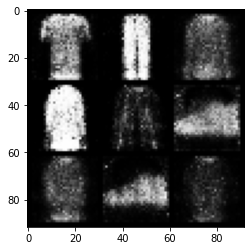

  1%|          | 5/938 [00:00<00:18, 49.23it/s]

epoch : 3


100%|██████████| 938/938 [00:19<00:00, 48.56it/s]


g_loss : 2.087500810623169, d_loss : 0.9861521124839783


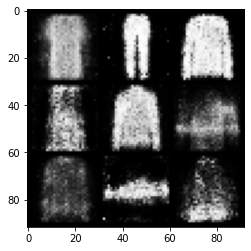

  0%|          | 0/938 [00:00<?, ?it/s]

epoch : 4


100%|██████████| 938/938 [00:19<00:00, 48.19it/s]


g_loss : 2.1571483612060547, d_loss : 0.9719849824905396


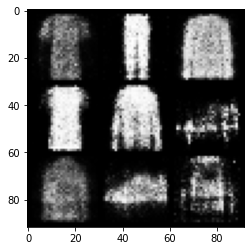

  0%|          | 0/938 [00:00<?, ?it/s]

epoch : 5


100%|██████████| 938/938 [00:19<00:00, 47.81it/s]


g_loss : 1.6327197551727295, d_loss : 0.8802517652511597


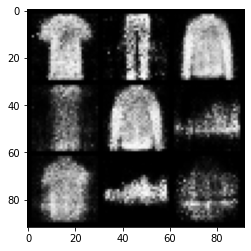

  0%|          | 0/938 [00:00<?, ?it/s]

epoch : 6


100%|██████████| 938/938 [00:19<00:00, 48.70it/s]


g_loss : 1.318864107131958, d_loss : 0.9857143759727478


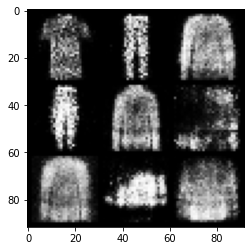

  0%|          | 0/938 [00:00<?, ?it/s]

epoch : 7


100%|██████████| 938/938 [00:19<00:00, 48.09it/s]


g_loss : 1.6558150053024292, d_loss : 0.8353751301765442


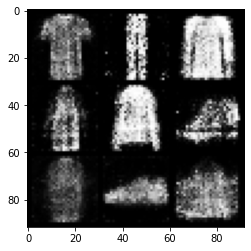

  0%|          | 0/938 [00:00<?, ?it/s]

epoch : 8


100%|██████████| 938/938 [00:19<00:00, 49.36it/s]


g_loss : 2.4265878200531006, d_loss : 0.7966344356536865


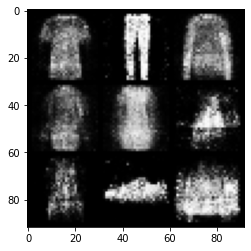

  0%|          | 0/938 [00:00<?, ?it/s]

epoch : 9


100%|██████████| 938/938 [00:19<00:00, 47.79it/s]


g_loss : 1.58400297164917, d_loss : 0.9311394095420837


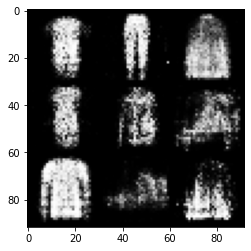

In [245]:
from tqdm import tqdm

num_epochs = 10
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('epoch : {}'.format(epoch))
    for _, (images, labels) in enumerate(tqdm(data_loader)):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = train_discriminator(len(real_images), discriminator, generator, d_optimizer, criterion, real_images, labels)
        g_loss = train_generator(batch_size, discriminator, generator, g_optimizer, criterion)
        
    generator.eval()
    print('g_loss : {}, d_loss : {}'.format(g_loss, d_loss))
    
    z = Variable(torch.randn(9,100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

## Step 6. Test Model

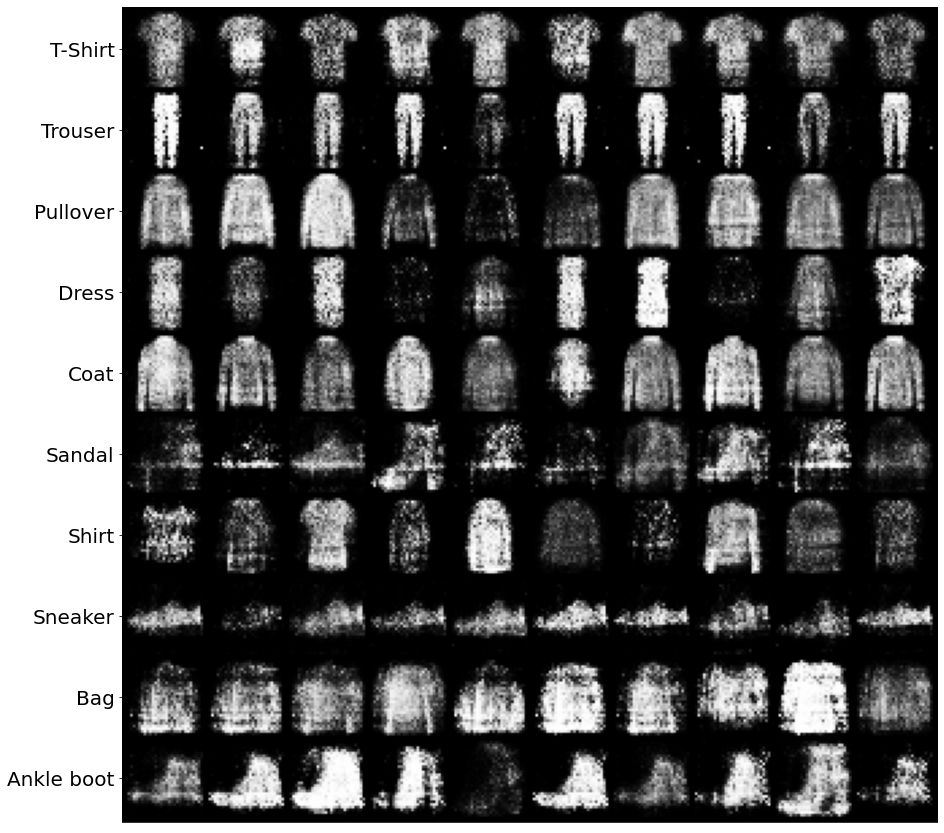

In [264]:
z = Variable(torch.randn(100,100)).cuda()
labels = Variable(torch.LongTensor([i for i in range(10) for j in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
plt.xticks([])
plt.yticks(np.arange(15,300,30),['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], fontsize=20)
plt.show();

> TEST CODE | LINE BY LINE

In [259]:
[i for i in range(10) for j in range(10)][:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [255]:
torch.LongTensor([i for i in range(10) for j in range(10)])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9])

In [256]:
torch.LongTensor([i for i in range(10) for j in range(10)]).shape

torch.Size([100])

In [265]:
np.arange(15,300,30) # text position of y-axis 

array([ 15,  45,  75, 105, 135, 165, 195, 225, 255, 285])

Thanks for studying this kernel with me so far, and I hope you continue to enjoy Pytorch!